<a href="https://colab.research.google.com/github/IllgamhoDuck/googleXproject/blob/master/Deutsch_Jozsa_Algorithm_with_Tensornetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deutsch-Jozsa Algorithm with Tensornetwork quantum simulator
**Implement Deutsch-Jozsa Algorithm using using Tensornetwork**



## Setting environment
- package install
- package import
- quantum simulator code

In [0]:
!pip install --quiet tensornetwork jax jaxlib qiskit nxpd pylatexenc

     |████████████████████████████████| 235kB 3.4MB/s 
     |████████████████████████████████| 122kB 53.5MB/s 
     |████████████████████████████████| 2.9MB 61.6MB/s 
     |████████████████████████████████| 2.7MB 38.8MB/s 
     |████████████████████████████████| 18.2MB 165kB/s 
     |████████████████████████████████| 92kB 12.2MB/s 
     |████████████████████████████████| 102kB 14.1MB/s 
     |████████████████████████████████| 1.4MB 45.9MB/s 
     |████████████████████████████████| 5.6MB 39.6MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 71kB 11.6MB/s 
     |████████████████████████████████| 573kB 58.8MB/s 
     |████████████████████████████████| 24.3MB 128kB/s 
     |████████████████████████████████| 2.3MB 42.3MB/s 


In [0]:
%matplotlib inline

# qiskit - test and visualize
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import execute, Aer
from qiskit.providers.aer import QasmSimulator

# tensornetwork
import numpy as np
import jax
import tensornetwork as tn
# np = jax.numpy

# math
import math

# test
import os
import time
import random
from tqdm import tqdm_notebook as tqdm

In [0]:
tn.set_default_backend("numpy") # <--- Super fast
# tn.set_default_backend("jax") # <--- This is painfully slow
# tn.set_default_backend("tensorflow") # <--- Slow :(
# tn.set_default_backend("pytorch") # <--- Doesn't support complex datatype :(
qasm_simulator = Aer.get_backend('qasm_simulator')
statevector_simulator = Aer.get_backend('statevector_simulator')

class colors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    CEND      = '\33[0m'
    CBOLD     = '\33[1m'
    CITALIC   = '\33[3m'
    CURL      = '\33[4m'
    CBLINK    = '\33[5m'
    CBLINK2   = '\33[6m'
    CSELECTED = '\33[7m'

    CBLACK  = '\33[30m'
    CRED    = '\33[31m'
    CGREEN  = '\33[32m'
    CYELLOW = '\33[33m'
    CBLUE   = '\33[34m'
    CVIOLET = '\33[35m'
    CBEIGE  = '\33[36m'
    CWHITE  = '\33[37m'

    CBLACKBG  = '\33[40m'
    CREDBG    = '\33[41m'
    CGREENBG  = '\33[42m'
    CYELLOWBG = '\33[43m'
    CBLUEBG   = '\33[44m'
    CVIOLETBG = '\33[45m'
    CBEIGEBG  = '\33[46m'
    CWHITEBG  = '\33[47m'

    CGREY    = '\33[90m'
    CRED2    = '\33[91m'
    CGREEN2  = '\33[92m'
    CYELLOW2 = '\33[93m'
    CBLUE2   = '\33[94m'
    CVIOLET2 = '\33[95m'
    CBEIGE2  = '\33[96m'
    CWHITE2  = '\33[97m'

    CGREYBG    = '\33[100m'
    CREDBG2    = '\33[101m'
    CGREENBG2  = '\33[102m'
    CYELLOWBG2 = '\33[103m'
    CBLUEBG2   = '\33[104m'
    CVIOLETBG2 = '\33[105m'
    CBEIGEBG2  = '\33[106m'
    CWHITEBG2  = '\33[107m'

color = colors

In [0]:
class QuantumSimulator():
    """Quantum simulator with tensornetwork"""
    def __init__(self, qbit_n):
        """
        Args:
            qbit_n: The number of total qubit size
            circuit: Where to store gate
        """
        assert qbit_n > 0, "Qubit size should be at least 1"
        self.qbit_n = qbit_n
        self.circuit = []

    def initialize_circuit(self):
        """
        Initialize the circuit to execute

        Args:
            qbits: Store the first initialized qubits
            measures: Store the edge that used for measure for each qubit
        """
        # Initialize qubit
        self.qbits = [tn.Node(np.array([1 + 0j, 0 + 0j])) for _ in range(self.qbit_n)]

        # Storing the Edge node that will be used to measure for each qubit
        self.measures = [self.qbits[i][0] for i in range(self.qbit_n)]
        self.amplitude = None
        self.result = {}
        self.result_prob = {}
    
    def connect_qubits(self):
        """
        Make the seperate tensornetworks to one tensornetwork using
        2 qubit identity gate
        CI - Control Identity
             [[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]]
        """
        for i in range(self.qbit_n - 1):
            self.add_ci(i, i + 1)

    def x(self, qbit_i):
        """
        Add X gate to specific 1 qubit index 
        x(qbit_i=0)
        """
        self.circuit.append(('x', qbit_i))

    def y(self, qbit_i):
        """
        Add Y gate to specific 1 qubit index 
        y(qbit_i=5)
        """
        self.circuit.append(('y', qbit_i))

    def z(self, qbit_i):
        """
        Add Z gate to specific 1 qubit index 
        z(qbit_i=3)
        """
        self.circuit.append(('z', qbit_i))

    def h(self, qbit_i):
        """
        Add H gate to specific 1 qubit index 
        h(qbit_i=2)
        """
        self.circuit.append(('h', qbit_i))

    def t(self, qbit_i):
        """
        Add T gate to specific 1 qubit index 
        t(qbit_i=0)
        """
        self.circuit.append(('t', qbit_i))

    def cx(self, qbit_c, qbit_t):
        """
        Add CX gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        cx(qbit_c=0, qbit_t=1)
        """
        self.circuit.append(('cx', qbit_c, qbit_t))

    def cy(self, qbit_c, qbit_t):
        """
        Add CY gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        cy(qbit_c=3, qbit_t=2)
        """
        self.circuit.append(('cy', qbit_c, qbit_t))

    def cz(self, qbit_c, qbit_t):
        """
        Add CZ gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        cz(qbit_c=2, qbit_t=4)
        """
        self.circuit.append(('cz', qbit_c, qbit_t))

    def ch(self, qbit_c, qbit_t):
        """
        Add CH gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        ch(qbit_c=1, qbit_t=3)
        """
        self.circuit.append(('ch', qbit_c, qbit_t))
    
    def ccx(self, qbit_c1, qbit_c2, qbit_t):
        """
        Add CCX gate to specific 3 qubit(control1 / control2 / target) index
        control and target qubit must be different 
        ccx(qbit_c1=0, qbit_c2=1 qbit_t=2)
        """
        self.circuit.append(('ccx', qbit_c1, qbit_c2, qbit_t))

    def add_x(self, qbit_i):
        X = tn.Node(np.array([[0, 1],
                              [1, 0]]))
        self.measures[qbit_i] ^ X[0]
        self.measures[qbit_i] = X[1]

    def add_y(self, qbit_i):
        Y = tn.Node(np.array([[0, 1j],
                              [-1j, 0]]))
        self.measures[qbit_i] ^ Y[0]
        self.measures[qbit_i] = Y[1]

    def add_z(self, qbit_i):
        Z = tn.Node(np.array([[1, 0],
                              [0, -1]]))
        self.measures[qbit_i] ^ Z[0]
        self.measures[qbit_i] = Z[1]

    def add_h(self, qbit_i):
        h_f = 1/math.sqrt(2)
        H = tn.Node(np.array([[h_f, h_f],
                              [h_f, -h_f]]))
        self.measures[qbit_i] ^ H[0]
        self.measures[qbit_i] = H[1]

    def add_t(self, qbit_i):
        e_j_pi = math.e ** ((1j * math.pi) / 4)
        T = tn.Node(np.array([[1, 0],
                              [0, e_j_pi]]))
        self.measures[qbit_i] ^ T[0]
        self.measures[qbit_i] = T[1]

    def add_cx(self, qbit_c, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        cx = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 0, 1],
                       [0, 0, 1, 0]])
        CX = tn.Node(cx.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CX[0]
        self.measures[qbit_t] ^ CX[1]
        self.measures[qbit_c] = CX[2]
        self.measures[qbit_t] = CX[3]

    def add_cy(self, qbit_c, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        cy = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 0, 1j],
                       [0, 0, -1j, 0]])
        CY = tn.Node(cy.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CY[0]
        self.measures[qbit_t] ^ CY[1]
        self.measures[qbit_c] = CY[2]
        self.measures[qbit_t] = CY[3]


    def add_cz(self, qbit_c, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        cz = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 1, 0],
                       [0, 0, 0, -1]])
        CZ = tn.Node(cz.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CZ[0]
        self.measures[qbit_t] ^ CZ[1]
        self.measures[qbit_c] = CZ[2]
        self.measures[qbit_t] = CZ[3]

    def add_ch(self, qbit_c, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
            h_f: hadamard factor
        """
        h_f = 1/math.sqrt(2)
        ch = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, h_f, h_f],
                       [0, 0, h_f, -h_f]])
        CH = tn.Node(ch.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CH[0]
        self.measures[qbit_t] ^ CH[1]
        self.measures[qbit_c] = CH[2]
        self.measures[qbit_t] = CH[3]

    def add_ci(self, qbit_c, qbit_t):
        """
        Control Identity matrix for connect
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        ci = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 1, 0],
                       [0, 0, 0, 1]])
        CI = tn.Node(ci.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CI[0]
        self.measures[qbit_t] ^ CI[1]
        self.measures[qbit_c] = CI[2]
        self.measures[qbit_t] = CI[3]

    def add_ccx(self, qbit_c1, qbit_c2, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        ccx = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                        [0, 1, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0, 0, 0, 0],
                        [0, 0, 0, 1, 0, 0, 0, 0],
                        [0, 0, 0, 0, 1, 0, 0, 0],
                        [0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 1],
                        [0, 0, 0, 0, 0, 0, 1, 0]])
        CCX = tn.Node(ccx.reshape((2, 2, 2, 2, 2, 2)))
        self.measures[qbit_c1] ^ CCX[0]
        self.measures[qbit_c2] ^ CCX[1]
        self.measures[qbit_t] ^ CCX[2]
        self.measures[qbit_c1] = CCX[3]
        self.measures[qbit_c2] = CCX[4]
        self.measures[qbit_t] = CCX[5]

    def generate_qiskit_circuit(self):
        """Visualize the gate using Qiskit"""
        qasm = self.circuit_to_qasm(self.circuit, self.qbit_n)
        ibmq_circuit = QuantumCircuit.from_qasm_str(qasm)
        return ibmq_circuit

    def circuit_to_qasm(self, circuit, qubit_size):
        # Add meta data
        qasm_text = 'OPENQASM 2.0;\ninclude "qelib1.inc";\n'

        # Add quantum bits and classical bits
        qasm_text += 'qreg q[{0}];\ncreg c[{0}];\n'.format(qubit_size)

        # Add quantum gates
        for gate in circuit:
            # 1 qubit gate
            if len(gate) == 2:
                qasm_text += '{0} q[{1}];\n'.format(gate[0], gate[1])
            # 2 qubit gate
            elif len(gate) == 3:
                qasm_text += '{0} q[{1}],q[{2}];\n'.format(gate[0], gate[1], gate[2])
            elif len(gate) == 4:
                qasm_text += '{0} q[{1}],q[{2}],q[{3}];\n'.format(gate[0],
                                                                  gate[1],
                                                                  gate[2],
                                                                  gate[3])
            else:
                raise NotImplementedError("Quantum simulator doesn't support qubit gates more than 3")

        # Add measure gate
        for qbit_i in range(qubit_size):
            qasm_text += 'measure q[{0}] -> c[{0}];\n'.format(qbit_i)

        return qasm_text

    def generate_result(self):
        for i in range(2 ** self.qbit_n):
            # Generate statevector
            statevector = ""
            for shift in range(self.qbit_n):
                statevector = str((i >> shift) & 1) + statevector
            
            # Check the amplitude
            amp = self.amplitude[self.bitstring_to_int(statevector)]
            amp = complex(str(amp))

            if amp == 0:
                continue

            # TODO: Figure out how to get value out of jax array
            self.result[statevector] = amp 
            self.result_prob[statevector] = (amp*amp.conjugate()).real

    def bitstring_to_int(self, bitstring):
        int_list = []
        for i in bitstring[::-1]:
            int_list.append(int(i))
        return tuple(int_list)

    def execute_circuit(self):
        """
        gate is structed as following
        1 qubit gate - (gate_name, qubit_index)
        2 qubit gate - (gate_name, qubit_control_index, qubit_target_index)
        """
        gate_1 = ['x', 'y', 'z', 'h', 't']
        gate_2 = ['cx', 'cy', 'cz', 'ch']
        gate_3 = ['ccx']
        gate_1_func = [self.add_x, self.add_y, self.add_z, self.add_h, self.add_t]
        gate_2_func = [self.add_cx, self.add_cy, self.add_cz, self.add_ch]
        gate_3_func = [self.add_ccx]

        # Connect the qubits
        for gate in self.circuit:
            if gate[0] in gate_2:
                i = gate_2.index(gate[0])
                gate_2_func[i](gate[1], gate[2])
            elif gate[0] in gate_1:
                i = gate_1.index(gate[0])
                gate_1_func[i](gate[1])
            elif gate[0] in gate_3:
                i = gate_3.index(gate[0])
                gate_3_func[i](gate[1], gate[2], gate[3])
            else:
                raise NotImplementedError("Gate {} is not supported".format(gate[0]))

        nodes = tn.reachable(self.qbits[0])
        self.amplitude = tn.contractors.greedy(nodes, output_edge_order=self.measures).tensor

    def clear_circuit(self):
        self.circuit = []

    def change_qubit_size(self, size):
        assert size > 0, "Qubit size should be at least 1"
        self.qbit_n = size

    def execute(self):
        assert self.qbit_n > 0, "Qubit size should be at least 1"
        self.initialize_circuit()
        self.connect_qubits()
        self.execute_circuit()
        self.generate_result()


## Introduction to Deutsch-Jozsa Algorithm

1. What is Deutsch-Jozsa Algorithm?
2. What is Deutsch's Algorithm?
3. Why is it good compared to classic computer?


In [0]:
#@title DUCKY!
%%html
<marquee style='width: 100%; color: blue;'><b>DUCKY! DUCKY! DUCKY! DUCKY! DUCKY!</b></marquee>

### 1. What is Deutsch-Jozsa Algorithm?
    Algorithm use oracle to check the blackbox function is
    constant(All output of function is same) or 
    balance(Output of function varies) in general n qubits

**Deutsch-Jozsa Algorithm**

The Deutsch–Jozsa algorithm is a quantum algorithm, proposed by David Deutsch and Richard Jozsa in 1992 with improvements by Richard Cleve, Artur Ekert, Chiara Macchiavello, and Michele Mosca in 1998. Although of little practical use, it is one of the first examples of a quantum algorithm that is exponentially faster than any possible deterministic classical algorithm and is the inspiration for Simon's Algorithm which is, in turn, the inspiration for Shor's Algorithm. It is also a deterministic algorithm, meaning that it always produces an answer, and that answer is always correct.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Deutsch-Jozsa-algorithm-quantum-circuit.png/800px-Deutsch-Jozsa-algorithm-quantum-circuit.png" width=400px>

For the Deutsch–Jozsa algorithm to work, the oracle computing $f(x)$ from $x$ has to be a quantum oracle which doesn't decohere $x$. It also mustn't leave any copy of $x$ lying around at the end of the oracle call.

The algorithm begins with the $n+1$ bit state $|0\rangle^{\otimes n} |1\rangle $. That is, the first n bits are each in the state $|0\rangle $ and the final bit is $|1\rangle $. A Hadamard transform is applied to each bit to obtain the state

**Now we are going to see how to induce the algorithm**

“Deutsch–Jozsa Algorithm.” Wikipedia, Wikimedia Foundation, 29 Jan. 2020, en.wikipedia.org/wiki/Deutsch–Jozsa_algorithm.


**Algorithm**

    Input state

$|0\rangle^{\otimes n}|1\rangle$

    Apply Hadamard gate to each qubits

$H^{\otimes n+1}|0\rangle^{\otimes n}|1\rangle$

$H^{\otimes n}|0\rangle^{\otimes n}H|1\rangle$

$H^{\otimes n}|0\rangle^{\otimes n} = \frac{1}{\sqrt{2^n}}\sum_{x=0}^{2^n-1}|x\rangle$

$H|1\rangle = \frac{|0\rangle - |1\rangle}{\sqrt{2}}$

$\therefore \frac{1}{\sqrt{2^n}}\sum_{x=0}^{2^n-1}|x\rangle\frac{|0\rangle - |1\rangle}{\sqrt{2}} = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} |x\rangle (|0\rangle - |1\rangle )$

    Apply the quantum oracle to X and Y

We have the function $f$ implemented as a quantum oracle. The oracle maps the state $f(|x\rangle|y\rangle) \mapsto |x\rangle|y\oplus f(x) \rangle $, where $\oplus$ is addition modulo 2. Applying the quantum oracle gives

$f(\frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} |x\rangle (|0\rangle - |1\rangle))$

$\frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} (f(|x\rangle|0\rangle - f(|x\rangle|1\rangle))$

$\frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} (|x\rangle|0 \oplus f(x) \rangle - |x\rangle|1\oplus f(x)\rangle))$

$\frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} |x\rangle (|f(x)\rangle - |1\oplus f(x)\rangle )$

    f(x) is either 0 or 1

$f(x) = 0$

$\rightarrow \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} |x\rangle (|0\rangle - |1\rangle )$

$f(x) = 1$

$\rightarrow \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} |x\rangle (|1\rangle - |0\rangle )$

$\therefore \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} (-1)^{f(x)} |x\rangle (|0\rangle - |1\rangle )$

    Ignore Y because this is will not be measured

$\frac{1}{\sqrt{2^n}}\sum_{x=0}^{2^n-1} (-1)^{f(x)} |x\rangle (\frac{|0\rangle - |1\rangle}{\sqrt{2}})$

Ignore $\frac{|0\rangle - |1\rangle}{\sqrt{2}}$

$\therefore \frac{1}{\sqrt{2^{n}}}\sum_{x=0}^{2^n-1} (-1)^{f(x)} |x\rangle$

    Apply Hadamard gate to X

$\frac{1}{\sqrt{2^n}}\sum_{x=0}^{2^n-1}(-1)^{f(x)} \left[ \frac{1}{\sqrt{2^n}} \sum_{y=0}^{2^n-1}(-1)^{x\cdot y}  |y\rangle \right] =
\frac{1}{2^n}\sum_{y=0}^{2^n-1} \left[\sum_{x=0}^{2^n-1}(-1)^{f(x)} (-1)^{x\cdot y}\right] |y\rangle $

where $x\cdot y=x_0 y_0\oplus x_1 y_1\oplus\cdots\oplus x_{n-1} y_{n-1} $ is the sum of the bitwise product

if $|x\rangle = |01\rangle$ and $|y\rangle = |11\rangle$

$x\cdot y = 0*0 + 1*1 = 1$

$\therefore \frac{1}{4}(-1)^{f(01)}(-1)^{1}|11\rangle$

    Calculate probability of the state |0>

Finally we examine the probability of measuring $|0\rangle^{\otimes n}$

$\frac{1}{2^n}\sum_{y=0}^{2^n-1} \left[\sum_{x=0}^{2^n-1}(-1)^{f(x)} (-1)^{x\cdot y}\right] |y\rangle $

$y = |0\rangle^{\otimes n}$

$\frac{1}{2^n}\left[\sum_{x=0}^{2^n-1}(-1)^{f(x)} (-1)^{x\cdot 0}\right] |0\rangle^{\otimes n} $

$\therefore \frac{1}{2^n}\left[\sum_{x=0}^{2^n-1}(-1)^{f(x)} \right] |0\rangle^{\otimes n} $


$amplitude = \frac{1}{2^n}\left[\sum_{x=0}^{2^n-1}(-1)^{f(x)} \right]$

$probability = \bigg|\frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)}\bigg|^2$


    Checkout f(x) is constant or balance

if $f(x) = 0$ constant
$\rightarrow \bigg|\frac{1}{2^n}\sum_{x=0}^{2^n-1}1\bigg|^2 = 1$

if $f(x) = 1$ constant
$\rightarrow \bigg|\frac{1}{2^n}\sum_{x=0}^{2^n-1}-1\bigg|^2 = \bigg|-1\bigg|^2 = 1$

if $f(x) = 0, 1$ balance
$\rightarrow \bigg|\frac{1}{2^n}\sum_{x=0}^{2^n-1}{-1, 1} \bigg|^2 = \bigg|x, -1 < x < 1 \bigg|^2 = 0 \leq result < 1$

**We can distinguish the f(x) is constant or balance by the probability of the |0> state. If f(x) is constant it will be 1 and otherwise we can know that f(x) is balance**



### 2. What is Deutsch's Algorithm?

    Special case of Deutsch-Jozsa Algorithm
    This is a case of 2 qubit

**Deutsch's algorithm**

Deutsch's algorithm is a special case of the general Deutsch–Jozsa algorithm. We need to check the condition $f(0)=f(1)$. It is equivalent to check $f(0)\oplus f(1)$ (where $\oplus$ is addition modulo 2, which can also be viewed as a quantum XOR gate implemented as a Controlled NOT gate, if zero, then $f$ is constant, otherwise $f$ is not constant.

“Deutsch–Jozsa Algorithm.” Wikipedia, Wikimedia Foundation, 29 Jan. 2020, en.wikipedia.org/wiki/Deutsch–Jozsa_algorithm.

**Algorithm**

    Detailed explain won't be written because it is
    explained at upper Deutsch-Jozsa algorithm in detail

**We start with 2 qubits**

$|0\rangle |1\rangle$

    Apply Hadamard gate to each qubits

$\frac{1}{2}(|0\rangle + |1\rangle)(|0\rangle - |1\rangle)$

    Apply the quantum oracle to X and Y

$\frac{1}{2}(|0\rangle(|f(0)\oplus 0\rangle - |f(0)\oplus 1\rangle) + |1\rangle(|f(1)\oplus 0\rangle - |f(1)\oplus 1\rangle))$

$=\frac{1}{2}((-1)^{f(0)}|0\rangle(|0\rangle - |1\rangle) + (-1)^{f(1)}|1\rangle(|0\rangle - |1\rangle))$

$=\frac{1}{2}\left((-1)^{f(0)}|0\rangle + (-1)^{f(1)}|1\rangle\right)(|0\rangle - |1\rangle)$

    Ignore Y because this is will not be measured

$\frac{1}{\sqrt 2}\left((-1)^{f(0)}|0\rangle + (-1)^{f(1)}|1\rangle\right)$

$\rightarrow \frac{1}{\sqrt{2}}\sum_{x=0}^{1}(-1)^{f(x)}|x\rangle$

    Apply Hadamard gate to X

$\frac{1}{\sqrt{2}}\sum_{x=0}^{1}(-1)^{f(x)} \left[\frac{1}{\sqrt{2}} \sum_{y=0}^{1}(-1)^{x\cdot y}  |y\rangle \right] =
\frac{1}{2}\sum_{y=0}^{1} \left[\sum_{x=0}^{1}(-1)^{f(x)} (-1)^{x\cdot y}\right] |y\rangle $

    Calculate probability of the state |0>

Finally we examine the probability of measuring $|0\rangle$

$\frac{1}{2}\sum_{y=0}^{1} \left[\sum_{x=0}^{1}(-1)^{f(x)} (-1)^{x\cdot y}\right] |y\rangle $

$y = |0\rangle$

$\frac{1}{2}\left[\sum_{x=0}^{1}(-1)^{f(x)} (-1)^{x\cdot 0}\right] |0\rangle$

$\therefore \frac{1}{2}\left[\sum_{x=0}^{1}(-1)^{f(x)} \right] |0\rangle $


$amplitude = \frac{1}{2}\left[\sum_{x=0}^{1}(-1)^{f(x)} \right]$

$probability = \bigg|\frac{1}{2}\sum_{x=0}^{1}(-1)^{f(x)}\bigg|^2$

    Checkout f(x) is constant or balance

if $f(x) = 0$ constant
$\rightarrow \bigg|\frac{1}{2}\sum_{x=0}^{1}1\bigg|^2 = 1$

if $f(x) = 1$ constant
$\rightarrow \bigg|\frac{1}{2}\sum_{x=0}^{1}-1\bigg|^2 = \bigg|-1\bigg|^2 = 1$

if $f(x) = 0, 1$ balance
$\rightarrow \bigg|\frac{1}{2}\sum_{x=0}^{1}{-1, 1} \bigg|^2 = \bigg|x = 0 \bigg|^2 = 0$

**If f(x) is constant it will be 1 and if (x) is 0 we can know that f(x) is balance**


### 3. Why is it good compared to classic computer?

    Quantum computer O(1)
    Classic computer O(n)

**Constant function**


$f(000) = f(0) = 0$

$f(001) = f(1) = 0$

$f(010) = f(2) = 0$

$f(011) = f(3) = 0$

$f(100) = f(4) = 0$

$f(101) = f(5) = 0$

$f(110) = f(6) = 0$

$f(111) = f(7) = 0$


**Classic computer**

    We need to check 8 times to know it is constant
    Because we cannot be sure till we check till end

$O(n)$

**Quantum computer**

    We make a superposition using Hadamard Gate
    And calculate every possible input at once

$O(1)$

**Quantum computer superposition makes quantum computer powerful than classical computer!**

## Deutsch with quantum simulator
    
    We learned so far what is deutsch's algorithm is
    Now we are going to check it by code

#### Deutsch algorithm code

**deutsch_algorithm**
    
    Circuit builder for n bits of deutsch_algorithm

**generate_result**
    
    Generate the statevector results except y qubit


In [0]:
def deutsch_algorithm(oracle, qubit_size=3):
    for o in oracle:
        circuit = QuantumSimulator(qubit_size)
   
        # x part
        for q_i in range(0, qubit_size - 1):
            circuit.h(q_i)

        # y part
        circuit.x(qubit_size - 1)
        circuit.h(qubit_size - 1)

        # oracle
        circuit.circuit.extend(o)

        # x part
        for q_i in range(0, qubit_size - 1):
            circuit.h(q_i)

        circuit.execute()
        yield circuit

def generate_result(result):
    result_dict = {}
    for statevector, probability in result.items():
        if result_dict.get(statevector[1:], None):
            result_dict[statevector[1:]] += probability
        else:
            result_dict[statevector[1:]] = probability
    return result_dict

#### 1 qubit deutsch's algorithm

In [0]:
oracle_constant = [[],
                   [('x', 1)]]

oracle_balance = [[('cx', 0, 1)],
                  [('cx', 0, 1), ('x', 1)]]

deutsch_constant = []
deutsch_balance = []
for example in deutsch_algorithm(oracle_constant, qubit_size=2):
    deutsch_constant.append(example)
for example in deutsch_algorithm(oracle_balance, qubit_size=2):
    deutsch_balance.append(example)

**1 qubit constant**

{'0': 0.9999999999999996, '1': 5.004680467665245e-34}


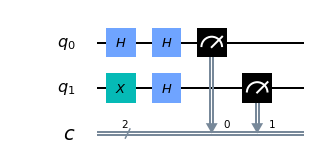

In [0]:
print(generate_result(deutsch_constant[0].result_prob))
deutsch_constant[0].generate_qiskit_circuit().draw(output='mpl')

{'0': 0.9999999999999996, '1': 5.004680467665245e-34}


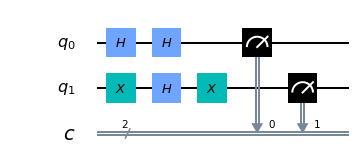

In [0]:
print(generate_result(deutsch_constant[1].result_prob))
deutsch_constant[1].generate_qiskit_circuit().draw(output='mpl')

**1 qubit balance**

{'0': 1.0573994819069698e-33, '1': 0.9999999999999996}


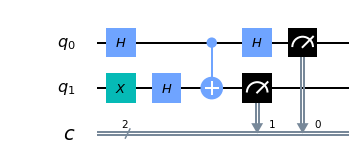

In [0]:
print(generate_result(deutsch_balance[0].result_prob))
deutsch_balance[0].generate_qiskit_circuit().draw(output='mpl')

{'1': 0.9999999999999996}


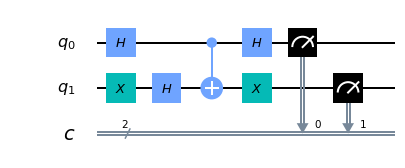

In [0]:
print(generate_result(deutsch_balance[1].result_prob))
deutsch_balance[1].generate_qiskit_circuit().draw(output='mpl')

#### 2 qubit deutsch-Jozsa algorithm

In [0]:
oracle_constant = [[],
                   [('x', 2)]]

oracle_balance = [[('ccx', 0, 1, 2)],
                  [('cx', 0, 2)],
                  [('cx', 1, 2)],
                  [('cx', 0, 2), ('cx', 1, 2)],
                  [('cx', 0, 2), ('x', 2)],
                  [('cx', 1, 2), ('x', 2)],
                  [('cx', 0, 2), ('cx', 1, 2), ('x', 2)]]

deutsch_constant = []
deutsch_balance = []
for example in deutsch_algorithm(oracle_constant, qubit_size=3):
    deutsch_constant.append(example)
for example in deutsch_algorithm(oracle_balance, qubit_size=3):
    deutsch_balance.append(example)

**2 qubit constant**

{'00': 0.9999999999999989, '01': 5.004680467665244e-34, '10': 5.004680467665244e-34, '11': 2.5046826583430023e-67}


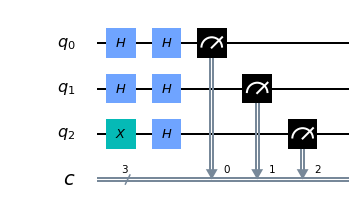

In [0]:
print(generate_result(deutsch_constant[0].result_prob))
deutsch_constant[0].generate_qiskit_circuit().draw(output='mpl')

{'00': 0.9999999999999992, '01': 5.004680467665244e-34, '10': 5.004680467665244e-34, '11': 2.5046826583430023e-67}


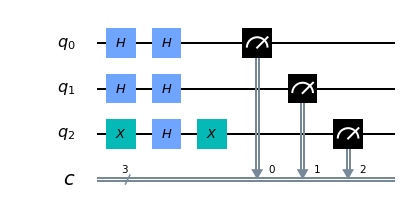

In [0]:
print(generate_result(deutsch_constant[1].result_prob))
deutsch_constant[1].generate_qiskit_circuit().draw(output='mpl')

**2 qubit balance**

{'00': 0.2499999999999998, '01': 0.2499999999999998, '10': 0.2499999999999998, '11': 0.2499999999999998}


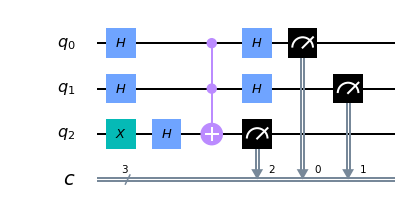

In [0]:
print(generate_result(deutsch_balance[0].result_prob))
deutsch_balance[0].generate_qiskit_circuit().draw(output='mpl')

{'00': 1.0573994819069687e-33, '01': 0.9999999999999992, '10': 9.287550367148156e-68, '11': 5.004680467665244e-34}


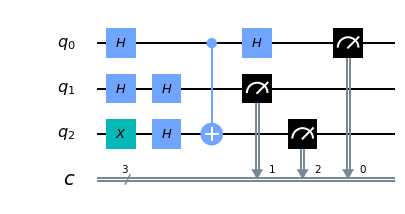

In [0]:
print(generate_result(deutsch_balance[1].result_prob))
deutsch_balance[1].generate_qiskit_circuit().draw(output='mpl')

{'00': 1.0573994819069692e-33, '01': 5.291946533619163e-67, '10': 0.9999999999999992, '11': 5.004680467665244e-34}


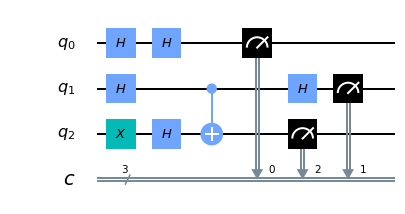

In [0]:
print(generate_result(deutsch_balance[2].result_prob))
deutsch_balance[2].generate_qiskit_circuit().draw(output='mpl')

{'00': 1.0573994819069692e-33, '01': 1.0573994819069687e-33, '10': 5.590468321685664e-67, '11': 0.9999999999999992}


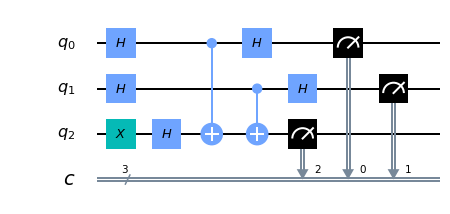

In [0]:
print(generate_result(deutsch_balance[3].result_prob))
deutsch_balance[3].generate_qiskit_circuit().draw(output='mpl')

{'00': 9.071053470133365e-35, '01': 0.9999999999999992, '10': 5.060094204003647e-67, '11': 5.004680467665244e-34}


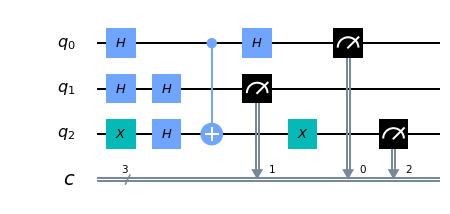

In [0]:
print(generate_result(deutsch_balance[4].result_prob))
deutsch_balance[4].generate_qiskit_circuit().draw(output='mpl')

{'00': 1.0573994819069692e-33, '01': 5.291946533619163e-67, '10': 0.9999999999999992, '11': 5.004680467665244e-34}


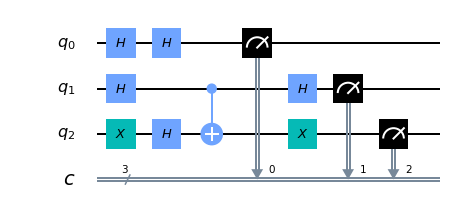

In [0]:
print(generate_result(deutsch_balance[5].result_prob))
deutsch_balance[5].generate_qiskit_circuit().draw(output='mpl')

{'00': 3.6886445537400536e-70, '01': 3.872928019572694e-37, '10': 9.071053470133365e-35, '11': 0.9999999999999992}


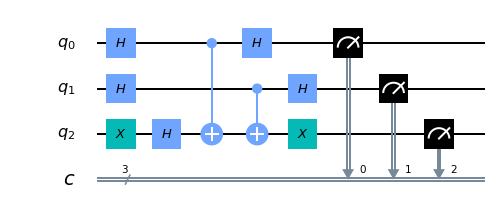

In [0]:
print(generate_result(deutsch_balance[6].result_prob))
deutsch_balance[6].generate_qiskit_circuit().draw(output='mpl')

#### n qubit deutsch-Jozsa algorithm

In [0]:
oracle_constant = [[],
                   [('x', 9)]]

oracle_balance = [[('cx', 0, 9)],
                  [('cx', 0, 1), ('cx', 1, 2), ('cx', 2, 3),
                   ('cx', 3, 4), ('cx', 4, 5), ('cx', 5, 6),
                   ('cx', 6, 7), ('cx', 7, 8),
                   ('cx', 8, 9),
                   ('cx', 7, 8), ('cx', 6, 7), ('cx', 5, 6),
                   ('cx', 4, 5), ('cx', 3, 4), ('cx', 2, 3),
                   ('cx', 1, 2), ('cx', 0, 1),
                   ('x', 9)]]

deutsch_constant = []
deutsch_balance = []
for example in deutsch_algorithm(oracle_constant, qubit_size=10):
    deutsch_constant.append(example)
for example in deutsch_algorithm(oracle_balance, qubit_size=10):
    deutsch_balance.append(example)

**n qubit constant**

{'000000000': 0.999999999999996, '000000001': 5.004680467665228e-34, '000000010': 5.004680467665228e-34, '000000011': 2.5046826583429957e-67, '000000100': 5.004680467665228e-34, '000000101': 2.5046826583429947e-67, '000000110': 2.5046826583429947e-67, '000000111': 1.2535136377909057e-100, '000001000': 5.004680467665228e-34, '000001001': 2.5046826583429947e-67, '000001010': 2.5046826583429947e-67, '000001011': 1.2535136377909057e-100, '000001100': 2.5046826583429947e-67, '000001101': 1.2535136377909057e-100, '000001110': 1.2535136377909057e-100, '000001111': 6.273435219004157e-134, '000010000': 5.004680467665228e-34, '000010001': 2.5046826583429947e-67, '000010010': 2.5046826583429947e-67, '000010011': 1.2535136377909057e-100, '000010100': 2.504682658342994e-67, '000010101': 1.2535136377909057e-100, '000010110': 1.2535136377909057e-100, '000010111': 6.2734352190041545e-134, '000011000': 2.504682658342994e-67, '000011001': 1.2535136377909057e-100, '000011010': 1.2535136377909057e-100, '0

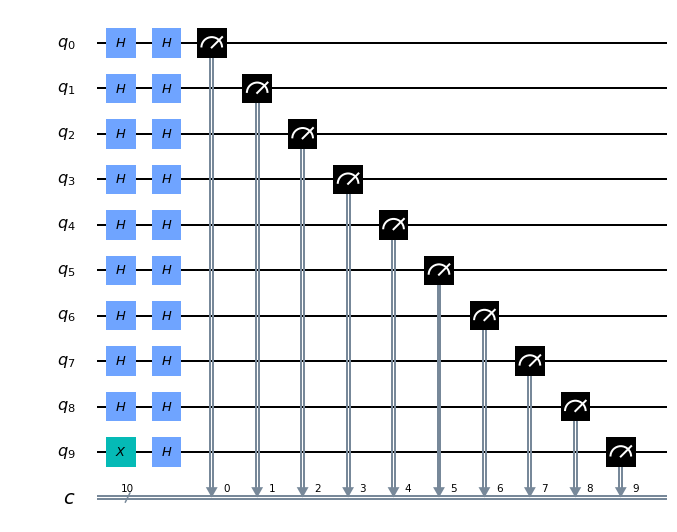

In [0]:
print(generate_result(deutsch_constant[0].result_prob))
deutsch_constant[0].generate_qiskit_circuit().draw(output='mpl')

{'000000000': 0.999999999999996, '000000001': 5.004680467665228e-34, '000000010': 5.004680467665228e-34, '000000011': 2.504682658342994e-67, '000000100': 5.004680467665228e-34, '000000101': 2.504682658342994e-67, '000000110': 2.504682658342994e-67, '000000111': 1.2535136377909057e-100, '000001000': 5.004680467665228e-34, '000001001': 2.504682658342994e-67, '000001010': 2.504682658342994e-67, '000001011': 1.2535136377909057e-100, '000001100': 2.504682658342994e-67, '000001101': 1.2535136377909057e-100, '000001110': 1.2535136377909057e-100, '000001111': 6.273435219004157e-134, '000010000': 5.004680467665228e-34, '000010001': 2.5046826583429947e-67, '000010010': 2.5046826583429947e-67, '000010011': 1.2535136377909052e-100, '000010100': 2.5046826583429947e-67, '000010101': 1.2535136377909052e-100, '000010110': 1.2535136377909052e-100, '000010111': 6.273435219004157e-134, '000011000': 2.5046826583429947e-67, '000011001': 1.2535136377909052e-100, '000011010': 1.2535136377909052e-100, '000011

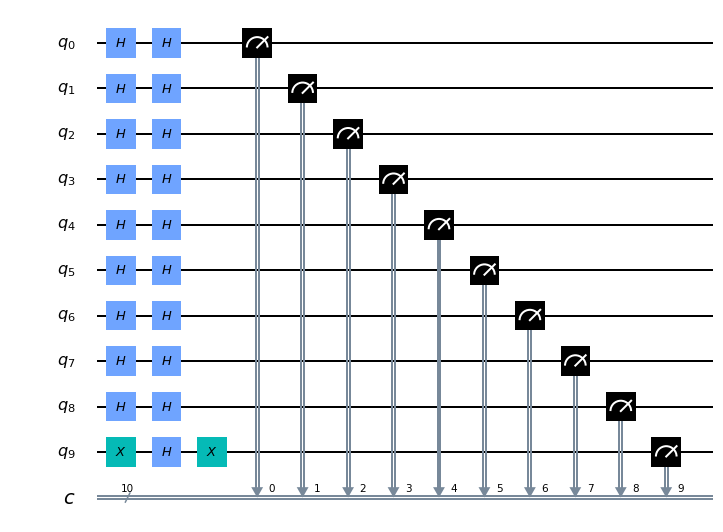

In [0]:
print(generate_result(deutsch_constant[1].result_prob))
deutsch_constant[1].generate_qiskit_circuit().draw(output='mpl')

**n qubit balance**

{'000000000': 2.6702688257759606e-36, '000000001': 0.999999999999996, '000000010': 9.687542299884442e-67, '000000011': 5.00468046766523e-34, '000000100': 9.687542299884442e-67, '000000101': 5.00468046766523e-34, '000000110': 1.651959794846651e-100, '000000111': 2.504682658342995e-67, '000001000': 3.096820354425621e-67, '000001001': 5.00468046766523e-34, '000001010': 1.651959794846651e-100, '000001011': 2.504682658342995e-67, '000001100': 1.651959794846651e-100, '000001101': 2.504682658342995e-67, '000001110': 7.444089104387017e-134, '000001111': 1.2535136377909064e-100, '000010000': 1.1975481781982107e-67, '000010001': 5.004680467665228e-34, '000010010': 1.072590408367533e-103, '000010011': 2.5046826583429947e-67, '000010100': 1.072590408367533e-103, '000010101': 2.5046826583429947e-67, '000010110': 1.6599201361690817e-134, '000010111': 1.2535136377909052e-100, '000011000': 1.072590408367533e-103, '000011001': 2.5046826583429947e-67, '000011010': 4.787805122359954e-134, '000011011': 1.

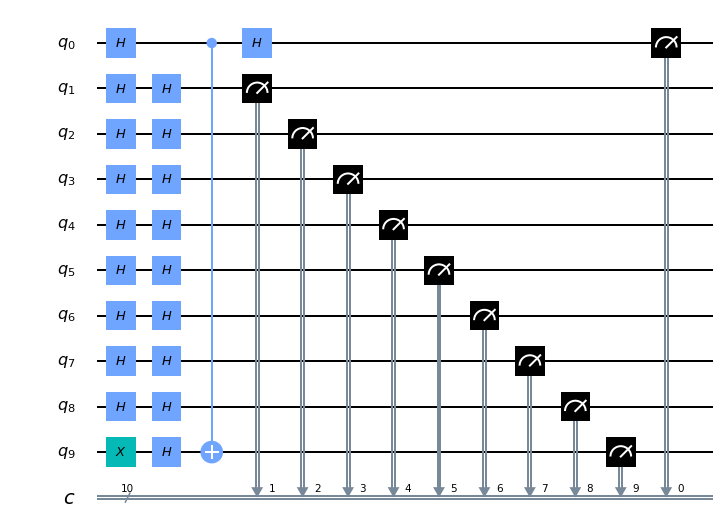

In [0]:
print(generate_result(deutsch_balance[0].result_prob))
deutsch_balance[0].generate_qiskit_circuit().draw(output='mpl')

{'000000000': 1.5563467254518633e-35, '000000001': 4.729086645574104e-99, '000000010': 4.729086645574104e-99, '000000011': 4.729086645574104e-99, '000000100': 1.8215779160626548e-132, '000000101': 1.8215779160626548e-132, '000000110': 1.8215779160626548e-132, '000000111': 4.4101019008543433e-97, '000001000': 9.16496676867171e-131, '000001001': 6.62426038120091e-168, '000001010': 6.62426038120091e-168, '000001011': 6.62426038120091e-168, '000001100': 4.953285532067044e-133, '000001101': 4.953285532067044e-133, '000001110': 4.953285532067044e-133, '000001111': 2.963651115467395e-71, '000010000': 4.656547752618551e-106, '000010001': 4.101419639307947e-167, '000010010': 4.101419639307947e-167, '000010011': 4.101419639307947e-167, '000010100': 1.3401884512538485e-206, '000010101': 1.3401884512538485e-206, '000010110': 1.3401884512538485e-206, '000010111': 2.4936278374762124e-164, '000011000': 2.2309964965720685e-131, '000011001': 4.4369168919033605e-166, '000011010': 4.4369168919033605e-166

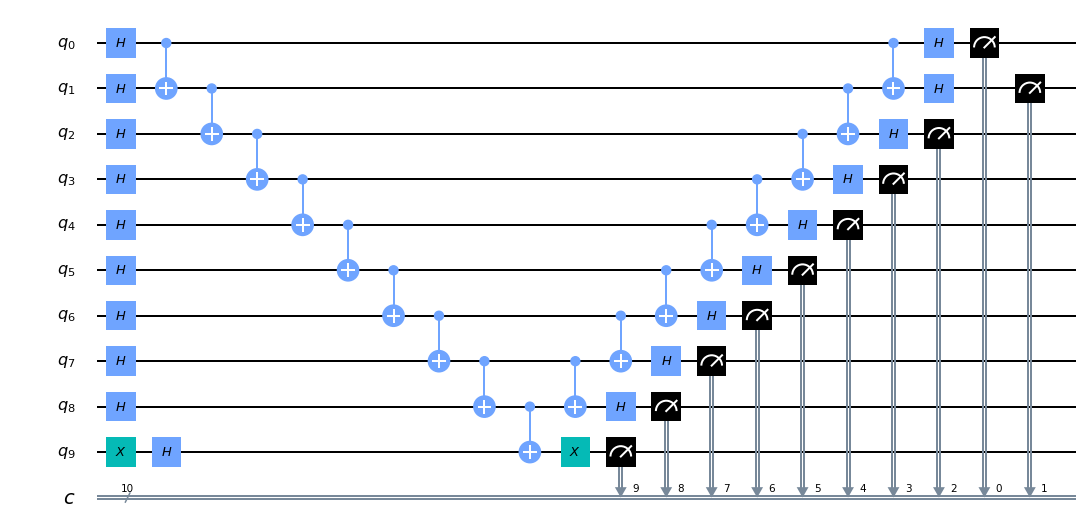

In [0]:
print(generate_result(deutsch_balance[1].result_prob))
deutsch_balance[1].generate_qiskit_circuit().draw(output='mpl')